#### Development of an Image-based Deep learning model for detection and diagnosis of CBB and CMD in Cassava plants

**Deep learning**: (a subset of machine learning) Is a type of neural network algorithm with multiple hidden layers (3 or more layers).
$$\sum_{n=1} x_i.w_i $$

**CNN**: An acronym for Convolutional Neural Network, this is a type of neural network that is used in image recognition and processing. 

In [190]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from PIL import Image
from rembg import remove
from keras.optimizers import Adam
from keras.metrics import Accuracy, AUC, F1Score, Recall, Precision
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory
from keras.applications import resnet50, EfficientNetB0
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization, Dense
from keras.layers import MaxPooling2D, Conv2D, Flatten
from keras.utils import to_categorical
import cv2
import random
import pathlib
import pickle


#### Data Training with SVM model

In [100]:
FIX_SIZE = 225

def prepare_data():  
    basepath = "data_all/"
    dataset_path = os.listdir(basepath)
    dataset_path = list(dataset_path)
    pixel_intensities = []
    class_intensities = []

    for image in dataset_path:
        image_read = cv2.imread(basepath+image)
        image_read = cv2.resize(image_read, dsize=(FIX_SIZE, FIX_SIZE))
        pixel_intensities.append(image_read)
        class_intensities.append(image[:3])
    
    pixel_intensities = np.array(pixel_intensities)
    class_intensities = np.array(class_intensities)
    return (pixel_intensities, class_intensities)

In [101]:
features, target = prepare_data()

features = features.reshape(len(features), -1)
target = target.flatten()

print(features.shape)
print(target.shape)

(225, 151875)
(225,)


In [102]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.2)
print(features_train.shape) 
print(target_train.shape) 

(180, 151875)
(180,)


In [103]:
svc = SVC()

fitted_model = svc.fit(features_train, target_train)
predictions = fitted_model.predict(features_test)



print(confusion_matrix(target_test, predictions))
print(accuracy_score(target_test, predictions))

[[ 2  0  3]
 [ 0 20  3]
 [ 2  2 13]]
0.7777777777777778


In [104]:
from sklearn.model_selection import GridSearchCV

model = SVC()

param_grid = {'C': [0.1, 1, 50, 100],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(model, param_grid=param_grid, refit=True, verbose=1)
grid.fit(features_train, target_train)

print(grid.best_estimator_)
grid_predictions = grid.predict(features_test)
print(confusion_matrix(grid_predictions, target_test))
print(accuracy_score(grid_predictions, target_test))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
SVC(C=0.1, gamma=1, kernel='poly')
[[ 2  0  2]
 [ 1 22  5]
 [ 2  1 10]]
0.7555555555555555


#### Implementing CNN with multiple layers on Cassava Dataset

In [105]:
features, target = prepare_data()
target = target.reshape(-1, 1)

encoder = LabelEncoder()
tar_ = encoder.fit_transform(target)

target = to_categorical(tar_, num_classes=3, dtype="float32")

print(target.shape)

(225, 3)


c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [106]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.2)

model = Sequential()
model.add(Conv2D(64, (3,3), 
                 kernel_initializer="he_uniform", 
                 activation="relu", 
                 input_shape=(225, 225, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(.4))
model.add(Conv2D(64, (3,3), kernel_initializer="he_uniform", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(.4))
model.add(Conv2D(128, (3,3), kernel_initializer="he_uniform", activation="relu"))
model.add(BatchNormalization()) 
model.add(MaxPooling2D(2,2))
model.add(Dropout(.4))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dense(3, activation='softmax'))

optimizer = Adam(learning_rate=.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(features_train, target_train, epochs=10, batch_size= 6, verbose=1, validation_data=(features_test, target_test))
result = model.evaluate(features_test, target_test, verbose = 0)
print(f'Accuracy of CNN model: {result[1] * 100}')


Epoch 1/10
30/30 [==============================] - 39s 1s/step - loss: 26.4309 - accuracy: 0.5667 - val_loss: 167.9644 - val_accuracy: 0.2444
Epoch 2/10
30/30 [==============================] - 36s 1s/step - loss: 5.2252 - accuracy: 0.7667 - val_loss: 35.9929 - val_accuracy: 0.4222
Epoch 3/10
30/30 [==============================] - 36s 1s/step - loss: 0.9772 - accuracy: 0.8500 - val_loss: 4.5272 - val_accuracy: 0.5556
Epoch 4/10
30/30 [==============================] - 37s 1s/step - loss: 0.4268 - accuracy: 0.9278 - val_loss: 2.4799 - val_accuracy: 0.6889
Epoch 5/10
30/30 [==============================] - 37s 1s/step - loss: 0.4383 - accuracy: 0.9500 - val_loss: 3.3266 - val_accuracy: 0.6889
Epoch 6/10
30/30 [==============================] - 37s 1s/step - loss: 0.0793 - accuracy: 0.9722 - val_loss: 3.0484 - val_accuracy: 0.7556
Epoch 7/10
30/30 [==============================] - 37s 1s/step - loss: 0.3799 - accuracy: 0.9333 - val_loss: 2.9962 - val_accuracy: 0.7556
Epoch 8/10
30/30

In [107]:
classes = ["cbb", "cmd", "chl"]

In [108]:
image = "Acadep/cmd/cmd 1.jpg"
image = cv2.imread(image)

image_resized = cv2.resize(image, (225, 225))
image = np.expand_dims(image_resized, axis=0)

pred = model.predict(image)
output_class = classes[np.argmax(pred)]
print(output_class)

1/1 [==============================] - 0s 156ms/step
cbb


#### Convolutionary Neural Network Implementation with Resnet Architecture

0


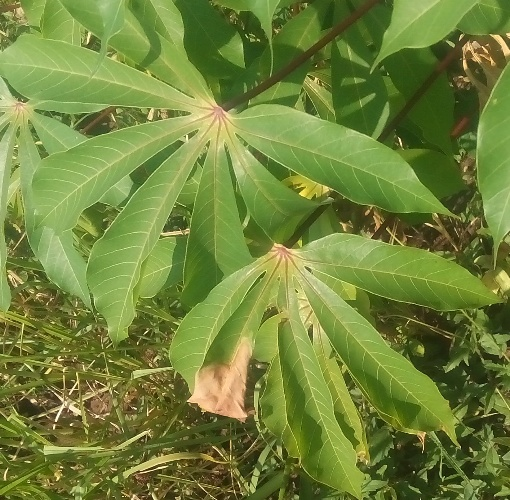

In [141]:
path = "Dataset/train/train/"
data_dir = pathlib.Path(path)

Cbb = list(data_dir.glob('cbb/*'))
Cmd = list(data_dir.glob('cmd/*'))
Chl = list(data_dir.glob('chl/*'))
# Chl = list(data_dir.glob('cbsd/*'))
# Chl = list(data_dir.glob('cgm/*'))

print(len(Chl))
Image.open(str(Cbb[0]))

In [268]:
image_height, image_width = 225,225
batch_size = 16

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='training',
    seed=123,
    label_mode='categorical',
    image_size=(image_height, image_width),
    batch_size=batch_size
)
val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='validation',
    seed=123,
    label_mode='categorical',
    image_size=(image_height, image_width),
    batch_size=batch_size
)

Found 3440 files belonging to 3 classes.
Using 3096 files for training.
Found 3440 files belonging to 3 classes.
Using 344 files for validation.


In [264]:
train_name = list(train_ds.class_indices.keys())
train_name


['cbb', 'cmd', 'healthy']

In [265]:
resnet_model = Sequential()

pretrained_model = resnet50.ResNet50(
    include_top=False,
    input_shape=(image_height, image_width, 3),
    pooling='max',
    classes=3,
    weights='imagenet'
)

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(3, activation='softmax'))

resnet_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_10 (Flatten)        (None, 2048)              0         
                                                                 
 dense_20 (Dense)            (None, 512)               1049088   
                                                                 
 dense_21 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 24638339 (93.99 MB)
Trainable params: 1050627 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [266]:
optimizer = Adam(learning_rate=0.001)

resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

In [267]:
epochs = 10

history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
) 

Epoch 1/10
81/81 [==============================] - 370s 5s/step - loss: 3.6125 - accuracy: 0.6796 - val_loss: 0.7491 - val_accuracy: 0.7730
Epoch 2/10
81/81 [==============================] - 443s 5s/step - loss: 0.7582 - accuracy: 0.7505 - val_loss: 0.8866 - val_accuracy: 0.7730
Epoch 3/10
81/81 [==============================] - 360s 4s/step - loss: 1.2837 - accuracy: 0.6900 - val_loss: 0.7246 - val_accuracy: 0.7916
Epoch 4/10
81/81 [==============================] - 384s 5s/step - loss: 0.7851 - accuracy: 0.7427 - val_loss: 0.7039 - val_accuracy: 0.7672
Epoch 5/10
81/81 [==============================] - 371s 5s/step - loss: 0.7868 - accuracy: 0.7427 - val_loss: 0.6136 - val_accuracy: 0.7893
Epoch 6/10
81/81 [==============================] - 352s 4s/step - loss: 0.8279 - accuracy: 0.7323 - val_loss: 0.5930 - val_accuracy: 0.7905
Epoch 7/10
81/81 [==============================] - 380s 5s/step - loss: 0.7636 - accuracy: 0.7509 - val_loss: 0.9533 - val_accuracy: 0.7730
Epoch 8/10
81

In [ ]:
## Saving pretrained model

pickle.dump(resnet_model, open('resnet_model.pkl', 'wb'))

In [200]:
from keras.models import model_from_json
json_model = resnet_model.to_json()#save the model architecture to JSON file
with open('streamlit_app/models/resnet_model.json', 'w') as json_file:
    json_file.write(json_model)#saving the weights of the model
model.save_weights('streamlit_app/models/resnet_model.h5')#Model loss and accuracy

In [201]:
with open('streamlit_app/models/resnet_model.json', 'r') as json_file:
    json_savedModel= json_file.read()#load the model architecture 
model_j = model_from_json(json_savedModel)
model_j.load_weights("streamlit_app/models/resnet_model.h5")

ValueError: Layer count mismatch when loading weights from file. Model expected 3 layers, found 8 saved layers.

In [202]:
dat = pd.read_json("streamlit_app/models/evaluation.json")
data = dat[["resnet_acc", "resnet_valacc"]]

df = data.reset_index()
df['index'] = df.index
x = pd.melt(df,id_vars="index", value_vars=['resnet_acc', 'resnet_valacc'])

x

,index,variable,value
0,0,resnet_acc,0.827519
1,1,resnet_acc,0.858850
2,2,resnet_acc,0.905685
3,3,resnet_acc,0.914729
4,4,resnet_acc,0.934432
5,5,resnet_acc,0.960271
6,6,resnet_acc,0.968669
7,7,resnet_acc,0.940245
8,8,resnet_acc,0.960917
9,9,resnet_acc,0.969638


In [210]:
resnet_accuracy = history.history['accuracy']
resnet_valaccuracy = history.history['val_accuracy']

resnet_loss = history.history['loss']
resnet_val_loss = history.history['val_loss']

plt_data = {
    "resnet_acc":resnet_accuracy, 
    "resnet_valacc":resnet_valaccuracy, 
    "resnet_loss": resnet_loss, 
    "resnet_val_loss": resnet_val_loss
}

dat = pd.DataFrame(plt_data)
dat.to_json("streamlit_app/models/evaluation.json")

pd.read_json("streamlit_app/models/evaluation.json")

,resnet_acc,resnet_valacc,resnet_loss,resnet_val_loss
0,0.898256,0.875000,0.321779,0.329534
1,0.934109,0.872093,0.176947,0.472216
2,0.941537,0.866279,0.178882,0.325032
3,0.958010,0.886628,0.117590,0.334031
4,0.956395,0.869186,0.122412,0.651557
5,0.967054,0.828488,0.104531,0.462613
6,0.950258,0.875000,0.150724,0.338332
7,0.970284,0.857558,0.086216,0.410720
8,0.981912,0.875000,0.054795,0.553393
9,0.991602,0.889535,0.036952,0.427932


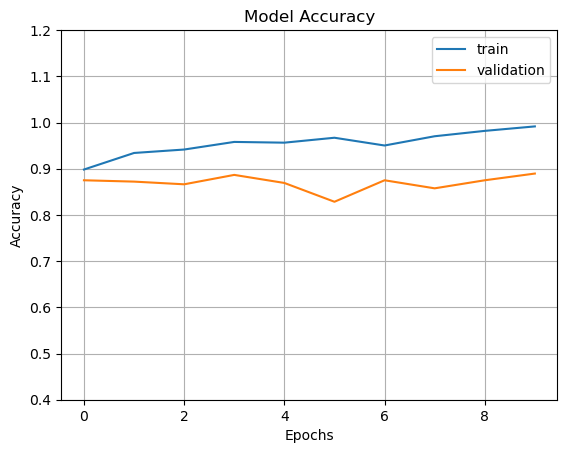

In [211]:
# fig1 = plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin = 0.4, ymax = 1.2)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

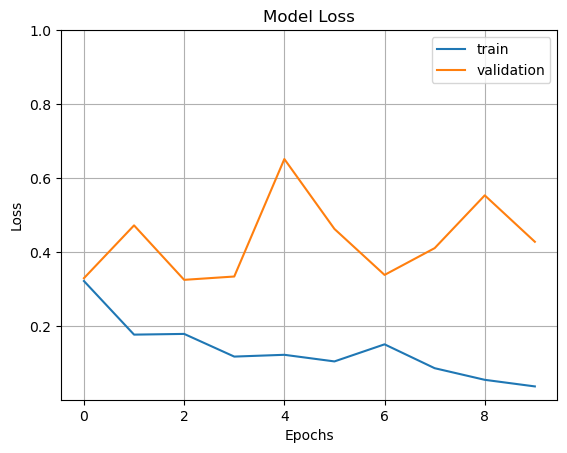

In [212]:
plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin = 0.001, ymax = 1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [213]:
image = cv2.imread(str(Cbb[1]))
image_resized = cv2.resize(image, dsize=(image_height, image_width))
image = np.expand_dims(image_resized, axis=0)

pred = resnet_model.predict(image)
print(pred)
output_class = train_name[np.argmax(pred)]
print(output_class)

1/1 [==============================] - 2s 2s/step
[[9.9911290e-01 2.7744134e-04 6.0971128e-04]]
cbb


In [ ]:
np.argmax(pred)

2

In [223]:
# image_name_map = {"cbb":"Cassava CB (Cassava Blight)", "cmd":"Cassava CM (Cassava Mosaic)"}


def putLabel(image, label_type = 'original', img_name="", output_class=""):
    
    label_type_choices = ['original','predicted']
    if label_type not in label_type_choices:
        raise ValueError("Invalid value for 'label_type'. Choose from: original, predicted")
        
    x,y,w,h = 0,0,175,75

    if label_type == "original":
        black = (0,0,0)
        label_text = img_name.upper()
        color = black
    else:
        green = (0,122,0)
        red = (0,0,255)
        true_val = output_class == img_name
        label_text = "positive" if true_val else "negative"
        color = green if true_val else red
        # img_sho = cv2.putText(img=image_resized,text="Okay", org=(50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,255,0))

    
    cv2.rectangle(image, (x, x), (x + w, y + h), color, -1)
    cv2.putText(
        image,
        label_text,  
        (x + w//10,y + h//2), 
        cv2.FONT_HERSHEY_SIMPLEX, 
        1, 
        (255,255,255),
        2, 
        cv2.LINE_AA)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return




1/1 [==============================] - 0s 267ms/step


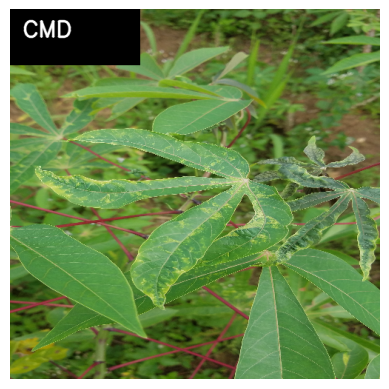

cmd


In [224]:
image_path = "Acadep/cmd/cmd 3.jpg"
image_name = os.path.basename(image_path)
img_name = (str(image_name))
img_name = img_name.lower()[:3]
image_ = cv2.imread(image_path)

image_resized = cv2.resize(image_, (500, 500))
image_resized_ = cv2.resize(image_, (image_height, image_width))
image = np.expand_dims(image_resized_, axis=0)

pred = resnet_model.predict(image)
output_class = train_name[np.argmax(pred)]

putLabel(image=image_resized,  img_name=img_name, output_class=output_class, label_type="original")

plt.axis("off")
plt.show()
print(output_class)

In [ ]:

images = "Acadep/cbb/"
dataset_path = os.listdir(images)
for image in dataset_path:
    # image_read = cv2.imread(images+image)
    # image_res = cv2.resize(image_read, (image_height, image_width))
    # image_res = np.expand_dims(image_res, axis=0)
    # predict = resnet_model.predict(image_res)
    # classes = train_name[np.argmax(predict)]
    image_name = os.path.basename(images+image)
    
    # image_name = os.path.basename(image_path)
    img_name = (str(image_name))
    img_name = img_name.lower()[:3]
    image_ = cv2.imread(images+image)

    image_resized = cv2.resize(image_, (500, 500))
    image_resized_ = cv2.resize(image_, (image_height, image_width))
    image = np.expand_dims(image_resized_, axis=0)

    pred = resnet_model.predict(image)
    output_class = train_name[np.argmax(pred)]
    
    # fig, sub_plots = plt.subplots(nrows=5, ncols=8, figsize=(20,10))
    # print(sub_plots)
    # sub_plots = sub_plots.flatten()
    

    green = (0,122,0)
    red = (0,0,255)
    true_val = output_class == img_name
    print(output_class)
    label_text = "positive" if true_val else "negative"
    color = green if true_val else red
    # img_sho = cv2.putText(img=image_resized,text="Okay", org=(50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,255,0))
    x,y,w,h = 0,0,175,75

    cv2.rectangle(image_resized, (x, x), (x + w, y + h), (0,0,0), -1)
    cv2.putText(
        image_resized,
        "CBB".upper(),  
        (x + w//10,y + h//2), 
        cv2.FONT_HERSHEY_SIMPLEX, 
        1, 
        (255,255,255),
        2, 
        cv2.LINE_AA)
    plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))

    plt.axis("off")
    plt.show()
    
    print(classes)
    

In [247]:
# predicted = resnet_model.predict_generator(val_ds)
class_names = val_ds.class_names

for images, labels in val_ds:
    for label in labels.numpy():
        class_name = class_names[label]
        print(f"Image belongs to class: {class_name}")

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
model = pickle.load(open("streamlit_app/models/resnet_model.pkl", "rb"))

# image = "test_download/Cassava Healthy.jpeg"
# image = cv2.imread(image)

# image_resized = cv2.resize(image, (image_height, image_width))
# image = np.expand_dims(image_resized, axis=0)
# model.predict(image)

model.history['accuracy']

TypeError: 'NoneType' object is not subscriptable

array([2, 2], dtype=int64)